In [0]:
!pip install pmdarima
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from pmdarima.arima import auto_arima

Load and clean data

In [0]:
currency_data = pd.read_csv('https://raw.githubusercontent.com/michael-northrup/cs_group_project/master/DEXUSEU.csv')
flight_data = pd.read_csv('https://raw.githubusercontent.com/michael-northrup/cs_group_project/master/flight_data.csv')

currency_data.loc[currency_data['DEXUSEU']=='.', 'DEXUSEU'] = np.nan
currency_data['DEXUSEU'] = currency_data['DEXUSEU'].astype(float).interpolate()
currency_data['Date'] = pd.to_datetime(currency_data['Date'], format='%m/%d/%Y')
currency_data.set_index(['Date'],inplace=True)

flight_data['Total'] = flight_data['Total'].apply(lambda x: int(x.replace(',','')))
flight_data['Date'] =  pd.to_datetime(flight_data['Date'], format='%m/%d/%Y')
flight_data.set_index(['Date'],inplace=True)


Split train/test

In [0]:
def train_test_split(dataset, percent):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  return dataset[:train_size], dataset[train_size:]

c_train, c_test = train_test_split(currency_data, .67)
f_train, f_test = train_test_split(flight_data, .67)

In [0]:
c_model = auto_arima(c_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=-25127.668, BIC=-25102.854, Fit time=1.539 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-25129.164, BIC=-25116.757, Fit time=0.368 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-25129.387, BIC=-25110.777, Fit time=0.206 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=-25129.453, BIC=-25110.843, Fit time=0.823 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-25131.087, BIC=-25124.883, Fit time=0.194 seconds
Total fit time: 3.139 seconds


In [0]:
c_predict = c_test.copy()

c_predict['DEXUSEU'] = c_model.predict(n_periods=len(c_predict))
c_resid = c_model.resid()
c_train_pred = c_train.DEXUSEU + c_resid

full_pred_c = c_train_pred.append(c_predict['DEXUSEU'])
full_residuals_c = full_pred_c- currency_data.DEXUSEU

train_score_c = (abs(c_resid)/c_train.DEXUSEU).mean()
test_score_c = (abs(c_test - c_predict)/c_test).mean()

Train Score: 0.004972970655089201
Test Score: DEXUSEU    0.123929
dtype: float64


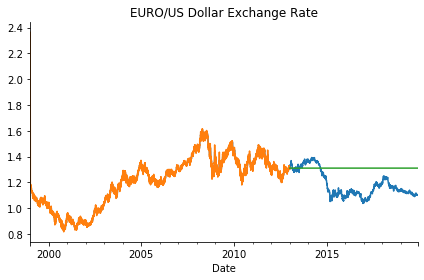

In [0]:
from google.colab import files

fig, ax = plt.subplots()
currency_data.DEXUSEU.plot(ax=ax)
c_train_pred.plot(ax=ax)
c_predict.plot(ax=ax)
sns.despine()
ax.get_legend().remove()
plt.title('EURO/US Dollar Exchange Rate')
fig.tight_layout()
plt.savefig('forex_ARIMA.png')
files.download("forex_ARIMA.png") 
print('Train Score:', train_score_c,)
print('Test Score:', test_score_c,)

In [0]:
f_model = auto_arima(f_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3890.127, BIC=3904.188, Fit time=1.098 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3893.286, BIC=3898.910, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3891.574, BIC=3902.823, Fit time=0.490 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3890.103, BIC=3901.352, Fit time=0.337 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3891.930, BIC=3894.742, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3892.496, BIC=3900.933, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3889.443, BIC=3903.504, Fit time=1.386 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3889.997, BIC=3901.246, Fit time=0.208 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3891.342, BIC=3908.215, Fit time=1.845 seconds
Fit ARIMA: order=(0, 1, 1) s

In [0]:
f_predict = f_test.copy()

f_predict['Total'] = f_model.predict(n_periods=len(f_predict))
f_resid = f_model.resid()
f_train_pred = f_train.Total + f_resid
full_pred = f_train_pred.append(f_predict['Total'])
full_residuals = full_pred- flight_data.Total

train_score_f = (abs(f_resid)/f_train.Total).mean()
test_score_f = (abs(f_test - f_predict)/f_test).mean()

Train Score: 0.04291904254145557
Test Score: Total    0.046977
dtype: float64


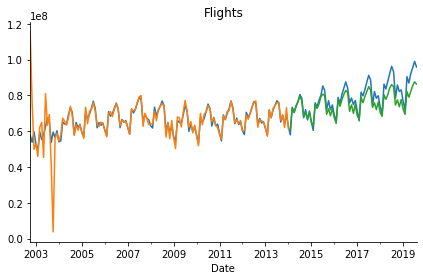

In [0]:
from google.colab import files

fig, ax = plt.subplots()
flight_data.Total.plot(ax=ax)
f_train_pred.plot(ax=ax)
f_predict.plot(ax=ax)
sns.despine()
ax.get_legend().remove()
plt.title('Flights')
fig.tight_layout()
plt.savefig('flight_ARIMA.png')
files.download("flight_ARIMA.png") 
print('Train Score:', train_score_f)
print('Test Score:', test_score_f)

LSTM Boosting

The concept that is going to be applied is using an LSTM model to boost the ARIMA by modeling the residuals. The reasoning behind this is that the arima models the linear/seasonal trends and the LSTM models the non-linear trends.

In [0]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
raw_seq = f_resid
n_steps = 4

X, y = split_sequence(raw_seq, n_steps)
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

model.fit(X, y, epochs=500, verbose=0)

In [0]:
x_input = np.array(full_residuals[0:4])
predict = np.array(full_residuals[0:4])
for i in range(len(full_residuals)-4):
  x_input_clean = x_input.reshape((1, n_seq, n_steps, n_features))
  prediction = model.predict(x_input_clean, verbose=0)
  predict = np.append(predict,prediction[0][0])
  x_input = np.append(x_input[1:],[full_residuals[i+4]])
boosted_predict = full_pred.copy()+predict

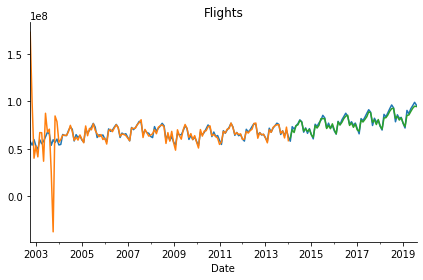

In [0]:
from google.colab import files

fig, ax = plt.subplots()
flight_data.Total.plot(ax=ax)
boosted_predict[:-67].plot(ax=ax)
boosted_predict[-67:].plot(ax=ax)

sns.despine()
plt.title('Flights')
fig.tight_layout()
plt.savefig('flight_ARIMA_LSTM.png')

In [0]:
files.download("flight_ARIMA_LSTM.png") 

print('Train ARIMA Square Error:')
arima_sqr_error = (full_pred-flight_data.Total)**2
print(math.sqrt(arima_sqr_error[:-67].mean()))
print('Train LSTM Boosted ARIMA Square Error:')
boosted_error = (boosted_predict-flight_data.Total)**2
print(math.sqrt(boosted_error[:-67].mean()))

Train ARIMA Square Error:
7720380.822710372
Train LSTM Boosted ARIMA Square Error:
14581259.353544133


In [0]:
print('Train ARIMA Error Percent:')
arima_sqr_error = abs(full_pred-flight_data.Total)/flight_data.Total
print(arima_sqr_error[:-67].mean())
print('Train LSTM Boosted ARIMA Error Percent:')
boosted_error = abs(boosted_predict-flight_data.Total)/flight_data.Total
print(boosted_error[:-67].mean())

Train ARIMA Error Percent:
0.042919042541455586
Train LSTM Boosted ARIMA Error Percent:
0.077117095751728


In [0]:
print('Test ARIMA Square Error:')
arima_sqr_error = (full_pred-flight_data.Total)**2
print(math.sqrt(arima_sqr_error[-67:].mean()))
print('Test LSTM Boosted ARIMA Square Error:')
boosted_error = (boosted_predict-flight_data.Total)**2
print(math.sqrt(boosted_error[-67:].mean()))

Test ARIMA Square Error:
4907007.725297395
Test LSTM Boosted ARIMA Square Error:
2156726.8930692878


In [0]:
print('Test ARIMA Error Percent:')
arima_sqr_error = abs(full_pred-flight_data.Total)/flight_data.Total
print(arima_sqr_error[-67:].mean())
print('Test LSTM Boosted ARIMA Error Percent:')
boosted_error = abs(boosted_predict-flight_data.Total)/flight_data.Total
print(boosted_error[-67:].mean())

Test ARIMA Error Percent:
0.046977012798514454
Test LSTM Boosted ARIMA Error Percent:
0.022888497094896584


Currency Data Boosting

In [0]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
raw_seq = c_resid
n_steps = 4
X, y = split_sequence(raw_seq, n_steps)
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

model.fit(X, y, epochs=500, verbose=0)

In [0]:
x_input = np.array(full_residuals_c[0:4])
predict_c = np.array(full_residuals_c[0:4])
for i in range(len(full_residuals_c)-4):
  x_input_clean = x_input.reshape((1, n_seq, n_steps, n_features))
  prediction_c = model.predict(x_input_clean, verbose=0)
  predict_c = np.append(predict_c,prediction_c[0][0])
  x_input = np.append(x_input[1:],[full_residuals_c[i+4]])
boosted_predict_c = full_pred_c.copy()+predict_c

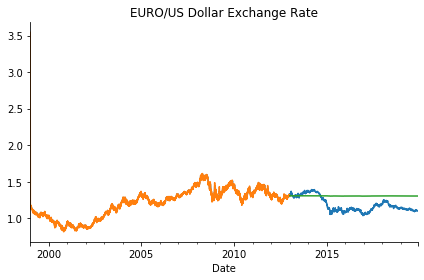

In [0]:
from google.colab import files

fig, ax = plt.subplots()
currency_data.DEXUSEU.plot(ax=ax)
boosted_predict_c[:-1801].plot(ax=ax)
boosted_predict_c[-1801:].plot(ax=ax)

sns.despine()
plt.title('EURO/US Dollar Exchange Rate')
fig.tight_layout()
plt.savefig('currency_ARIMA_LSTM.png')
files.download("currency_ARIMA_LSTM.png") 


In [0]:

print('Train ARIMA Square Error:')
arima_sqr_error = (full_pred_c-currency_data.DEXUSEU)**2
print(arima_sqr_error[:-1801].mean())
print('Train LSTM Boosted ARIMA Square Error:')
boosted_error = (boosted_predict_c-currency_data.DEXUSEU)**2
print(boosted_error[:-1801].mean())

print('Train ARIMA Error Percent:')
arima_sqr_error = abs(full_pred_c-currency_data.DEXUSEU)/currency_data.DEXUSEU
print(arima_sqr_error[:-1801].mean())
print('Train LSTM Boosted ARIMA Error Percent:')
boosted_error = abs(boosted_predict_c-currency_data.DEXUSEU)/currency_data.DEXUSEU
print(boosted_error[:-1801].mean())

Train ARIMA Square Error:
0.0004420111096722625
Train LSTM Boosted ARIMA Square Error:
0.0015972401181236398
Train ARIMA Error Percent:
0.004972970655089199
Train LSTM Boosted ARIMA Error Percent:
0.005803990483037894


In [0]:
print('Test ARIMA Square Error:')
arima_sqr_error = (full_pred_c-currency_data.DEXUSEU)**2
print(arima_sqr_error[-1801:].mean())
print('Test LSTM Boosted ARIMA Square Error:')
boosted_error = (boosted_predict_c-currency_data.DEXUSEU)**2
print(boosted_error[-1801:].mean())

print('Test ARIMA Error Percent:')
arima_sqr_error = abs(full_pred_c-currency_data.DEXUSEU)/currency_data.DEXUSEU
print(arima_sqr_error[-1801:].mean())
print('Test LSTM Boosted ARIMA Error Percent:')
boosted_error = abs(boosted_predict_c-currency_data.DEXUSEU)/currency_data.DEXUSEU
print(boosted_error[-1801:].mean())

Test ARIMA Square Error:
0.025335997566629662
Test LSTM Boosted ARIMA Square Error:
0.023794121497485887
Test ARIMA Error Percent:
0.12392924060165719
Test LSTM Boosted ARIMA Error Percent:
0.12036828009482584
